In [1]:
import gym
import numpy as np
import math
from collections import deque


class MountainCarAgent():
    def __init__(self, buckets=(4, 2), num_episodes=300, min_lr=0.1, min_explore=0.2, discount=0.9, decay=25, n_step=100, early_stopping_threshold=15):
        self.early_stopping_threshold = early_stopping_threshold
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_explore = min_explore
        self.discount = discount
        self.decay = decay
        self.n_step = n_step
        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = [self.env.observation_space.high[0], self.env.observation_space.high[1]]
        self.lower_bounds = [self.env.observation_space.low[0], self.env.observation_space.low[1]]
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))
        self.N = np.zeros(self.buckets + (self.env.action_space.n,))
    
    # Rest of the class code remains unchanged.

    def get_explore_rate(self, t):
        return max(self.min_explore, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_lr(self, t):
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def mc_update(self, current_state, new_state, reward, old_action, action,i):
        q = self.Q_table[current_state][old_action]
        q += (1/i)*(reward - q)
        self.Q_table[current_state][old_action] = q
 
    def sarsa_update(self, current_state, new_state, reward, old_action, action,i):
        q = self.Q_table[current_state][old_action]
        q += self.lr*(reward+self.discount*self.Q_table[new_state][action] - q)
        self.Q_table[current_state][old_action] = q

    def ql_update(self, current_state, new_state, reward, old_action, action,i):
        q = self.Q_table[current_state][old_action]
        q += self.lr*(reward+self.discount*np.max(self.Q_table[new_state]) - q)
        self.Q_table[current_state][old_action] = q
            
    def expected_sarsa_update(self, current_state, new_state, reward, old_action, action, i):
        q = self.Q_table[current_state][old_action]
        
        # Create a policy using the current Q-table
        policy = np.ones(self.env.action_space.n) * self.explore_rate / self.env.action_space.n
        
        best_action = np.argmax(self.Q_table[new_state])
        
        policy[best_action] += (1.0 - self.explore_rate)
        # Calculate the expected value
        
        expected_value = np.sum(policy * self.Q_table[new_state])
        # Calculate the new Q-value
        
        q += self.lr*(reward + self.discount * expected_value - q)
        self.Q_table[current_state][old_action] = q
        
        

    def off_policy_expected_sarsa_update(self, current_state, new_state, reward, old_action, i):
        q = self.Q_table[current_state][old_action]
        
        # Create a greedy policy using the current Q-table
        policy = np.zeros(self.env.action_space.n)
        
        best_action = np.argmax(self.Q_table[new_state])
        
        policy[best_action] = 1.0
        # Calculate the expected value
        expected_value = np.sum(policy * self.Q_table[new_state])
        
        # Calculate the new Q-value
        q += self.lr * (reward + self.discount * expected_value - q)
        self.Q_table[current_state][old_action] = q


        
    def choose_action(self, state):
        x = (np.random.uniform(0, 1))
        if  x < self.explore_rate:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q_table[state])
        

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(np.round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)
    
    def n_step_sarsa_update(self, current_state, new_state, reward, old_action, action, steps):
        self.N[current_state][old_action] += 1

        if steps < self.n_step:
            return
        
        ### Note that popleft() both returns and removes the leftmost item from the deque,
        ###so this code is both accessing and removing the entries after they've been used. 
        ### The "mod n+1" behavior is implicit in this design.

        returns = sum(self.discount**i * self.rewards[i] for i in range(self.n_step))
        returns += self.discount**self.n_step * self.Q_table[new_state][action]

        
        old_state, old_action = self.state_actions.popleft()
        q = self.Q_table[old_state][old_action]
        q += self.lr * (returns - q)
        self.Q_table[old_state][old_action] = q

    def train(self, method='mc'):
        losses = []
        win_counter = 0 
        for i, e in enumerate(range(self.num_episodes)):
            if i%100==0: 
                print(f"episode: {i}")
                print(f"self.Q_table:{self.Q_table}")
                
            i += 1
            total_R = 0
            current_state = self.discretize_state(self.env.reset(options={(-0.6,-0.4), 0})[0])
            
            if i%100==0: 
                print(f"current state:{current_state}")
                
            self.lr = self.get_lr(e)
            self.explore_rate = self.get_explore_rate(e)
            terminated, truncated, position, end = False,False,False,False
            old_action = 1
            steps = 0

            # Added for n-step SARSA
            
            ###The 'tau' from the n-step SARSA algorithm is not explicitly represented in this code. 
            ###Instead, the dequeues self.rewards and self.state_actions keep track of the last 'n' rewards
            ### and state-action pairs.
            ###The variable 'steps' in the train function essentially acts as the time 't' from 
            ###the n-step SARSA algorithm.
            
            self.rewards = deque(maxlen=self.n_step)
            self.state_actions = deque(maxlen=self.n_step)

            while not any([terminated, truncated, position, end]):
                steps += 1
                end = steps == num_steps_in_episode
                ## agent selects an action (A_t) based on the current state, executes that action in the environment, 
                # and observes the resulting reward and new state. 
                action = self.choose_action(current_state)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                
                position = obs[0] >= 0.5
                new_state = self.discretize_state(obs)
                
                self.rewards.append(reward)
                self.state_actions.append((current_state, action))
                
                total_R += reward

                if method == 'n_step_sarsa':
                    self.n_step_sarsa_update(current_state, new_state, total_R, old_action, action, steps)
                    
                current_state = new_state
                old_action = action
            losses.append(total_R)
            
            if position == True:
                win_counter += 1  # Increment win counter
                print('At episode: ', e, ', Win!!!', sep='')
                if win_counter == self.early_stopping_threshold:  # Check win counter
                    print(f'Agent has won {self.early_stopping_threshold} times! Stopping training...')
                    break
                    
#             if position == True:
#                 print('At episode: ', e, ', Win!!!', sep='')

        print('Finished training!')
        return losses


    def run(self):
       
        self.env = gym.make('MountainCar-v0', render_mode='human')
        current_state = self.discretize_state(self.env.reset(options={(-0.6,-0.4), 0})[0])
        steps=0
        termintated, truncated, position, end = False,False,False,False
        while not any([termintated, truncated, position, end]):
            steps+=1
            end = steps==num_steps_in_episode
            action = self.choose_action(current_state)
#             print(action)
            obs, reward, termintated, truncated, _ = self.env.step(action)
            position = obs[0]>=0.5
            current_state = self.discretize_state(obs)
        if position == True:
            print('Win!!!')
            
        self.env.close()

        


### N-Step SARSA

In [2]:

        
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np


def moving_average(arr, window_size=10):
    ret = np.cumsum(arr, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size



TD_N= 100

num_steps_in_episode =2000

agent_n_step_sarsa = MountainCarAgent(num_episodes = 350, early_stopping_threshold=10)

losses_n_step_sarsa = agent_n_step_sarsa.train(method='n_step_sarsa')

agent_n_step_sarsa.run()



episode: 0
self.Q_table:[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]]
current state:(1, 0)
episode: 100
self.Q_table:[[[  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[-10.         -10.         -10.        ]
  [ -9.99999694 -10.          -9.99999993]]

 [[ -8.72379914  -4.02304814  -4.02304814]
  [ -8.72379914  -6.42760465  -4.02304814]]

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]]]
current state:(1, 0)
episode: 200
self.Q_table:[[[ -9.96277379  -9.87976422  -9.76870259]
  [ -8.94410754  -9.1427084   -9.30292906]]

 [[-10.          -9.99999999  -9.99999984]
  [-10.         -10.         -10.        ]]

 [[ -9.99999609  -9.99999938 -10.        ]
  [ -9.99999893  -9.99999904  -9.99999937]]

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]]]
At episode: 205, Win!!!
At episode: 236, Win!!!
At episode: 238, W

<img src="on-policy-sarsa.png" width="500"/>


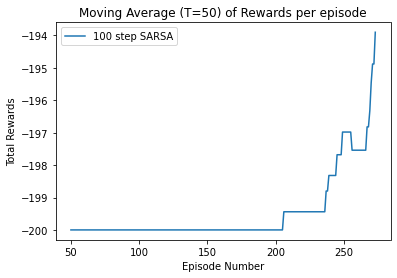

In [3]:
ma_losses_n_step_sarsa = moving_average(losses_n_step_sarsa, window_size=50)
x= np.arange(0,len(ma_losses_n_step_sarsa))

x = [x+50 for x in x]
plt.plot(x, ma_losses_n_step_sarsa, label=f'{TD_N} step SARSA')

plt.title("Moving Average (T=50) of Rewards per episode")
plt.xlabel("Episode Number")
plt.ylabel("Total Rewards")
plt.legend()

log_df = pd.DataFrame({'rewards':ma_losses_n_step_sarsa})
log_df['method'] = 'N step SARSA'
log_df.to_csv("MountainCar_n_step_sarsa.csv")

### Combinations of parameters that worked: 

<img src="TD(100).png" width="500"/>


{'buckets': (4, 2), 'num_episodes': 500, 'min_lr': 0.1, 'min_explore': 0.1, 'discount': 0.9, 'decay': 25, 'n_step': 100, 'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<MountainCarEnv<MountainCar-v0>>>>>, 'upper_bounds': [0.6, 0.07], 'lower_bounds': [-1.2, -0.07], 'Q_table': array([[[ -9.99450167,  -9.99160768,  -9.99303862],
        [ -9.96132003,  -9.87478488,  -9.87694384]],

       [[ -9.99999961,  -9.99999973,  -9.9999997 ],
        [-10.        , -10.        ,  -9.99999999]],

       [[ -9.9999986 ,  -9.99999904,  -9.99999997],
        [ -9.99999442,  -9.99999275,  -9.99998366]],

       [[ -2.71      ,   0.        ,  -1.        ],
        [ -4.68556344,  -4.68548123,  -6.86189404]]]), 'N': array([[[5.8700e+02, 1.0430e+03, 1.1120e+03],
        [4.8500e+02, 9.2400e+02, 1.3240e+03]],

       [[2.3442e+04, 1.1459e+04, 7.0120e+03],
        [9.7270e+03, 1.0416e+04, 1.5635e+04]],

       [[2.2220e+03, 1.5940e+03, 7.6700e+02],
        [9.2900e+02, 1.9670e+03, 4.6540e+03]],

       [[1.7700e+02, 5.7000e+01, 9.0000e+00],
        [4.1600e+02, 3.9600e+02, 1.8200e+02]]]), 'lr': 0.1, 'explore_rate': 0.1, 'rewards': deque([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], maxlen=100), 'state_actions': deque([((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 0), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 2), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((0, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 2), ((1, 1), 1), ((1, 1), 0), ((1, 1), 2), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((1, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 2), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 1), 1), ((2, 0), 1), ((2, 0), 0), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 2), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((2, 0), 1), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((1, 0), 0), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1), ((0, 0), 1)], maxlen=100)}
    
    

In [ ]:
print(vars(agent_n_step_sarsa))